# Plots

In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from imageio import imread
from wordcloud import WordCloud
import time

gridc = (1., 1., 1)
plt.rcParams['grid.color'] = gridc
plt.rcParams["axes.edgecolor"] = (0.898, 0.925, 0.965, 1)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
sns.set(style='darkgrid', context='talk', palette='colorblind')

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>div#site { height: 100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
data_path = '../data/'
image_path = '../images/'

venue_short = 'iclr2023'
# date = time.strftime("%Y%m%d")
date = '20221120'
image_path_latest = image_path + date + '/'
df = pd.read_csv(f'{data_path}{venue_short}_{date}.csv')

df_old = pd.read_csv(f'{data_path}{venue_short}_20221105.csv')

# get average rating for each paper from ratings column
df['ratings_avg'] = df['ratings'].apply(lambda x: np.mean(eval(x)))
df['ratings_std'] = df['ratings'].apply(lambda x: np.std(eval(x)))
df['confidence_avg'] = df['confidences'].apply(lambda x: np.mean(eval(x)))
df['confidence_std'] = df['confidences'].apply(lambda x: np.std(eval(x)))

# get ratings old
df['ratings_avg_old'] = df_old['ratings'].apply(lambda x: np.mean(eval(x)))
df['ratings_old'] = df_old['ratings'].apply(lambda x: eval(x))

/home/botu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/botu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/botu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/botu/.local/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/botu/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [82]:
df.head()

,id,title,keywords,ratings,confidences,withdraw,review_lengths,ratings_avg,ratings_std,confidence_avg,confidence_std,ratings_avg_old,ratings_old
0,kRvZ2PcsxjJj,Quantum reinforcement learning,"['quantum reinforcement learning', 'multi-agen...","[1, 1, 1, 1]","[5, 5, 5, 5]",1,"[45, 49, 25, 283]",1.000000,0.000000,5.000000,0.000000,1.000000,"[1, 1, 1, 1]"
1,RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,[],"[5, 6, 8]","[4, 3, 3]",0,"[443, 274, 401]",6.333333,1.247219,3.333333,0.471405,6.333333,"[5, 6, 8]"
2,N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,"['Lateral Inhibition', 'Convolutional Neural N...","[3, 5, 3, 1]","[5, 5, 5, 5]",0,"[333, 360, 362, 304]",3.000000,1.414214,5.000000,0.000000,3.000000,"[3, 5, 3, 1]"
3,tmIiMPl4IPa,Factorized Fourier Neural Operators,"['fourier transform', 'fourier operators', 'pd...","[8, 6, 3, 8, 3]","[5, 4, 4, 2, 2]",0,"[203, 142, 323, 520, 635]",5.600000,2.244994,3.400000,1.200000,5.600000,"[8, 6, 3, 8, 3]"
4,mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,"['Pruning', 'Data Free', 'Model Compression']","[8, 6, 6]","[3, 2, 3]",0,"[302, 90, 257]",6.666667,0.942809,2.666667,0.471405,6.666667,"[8, 6, 6]"


### Keywords

In [83]:
# Get list
df['keywords'] = df['keywords'].apply(eval)

data = df['keywords']
keywords = {}
for kw in data:
    kw = [_k.lower().strip() for _k in kw]
    for _k in kw:
        if _k in keywords.keys():
            keywords[_k] += 1
        else:
            keywords[_k] = 1
# sort values
keywords = {k: v for k, v in sorted(keywords.items(), key=lambda item: item[1])[::-1]}
keywords = pd.Series(keywords).sort_values(ascending=True)
# sort keyword

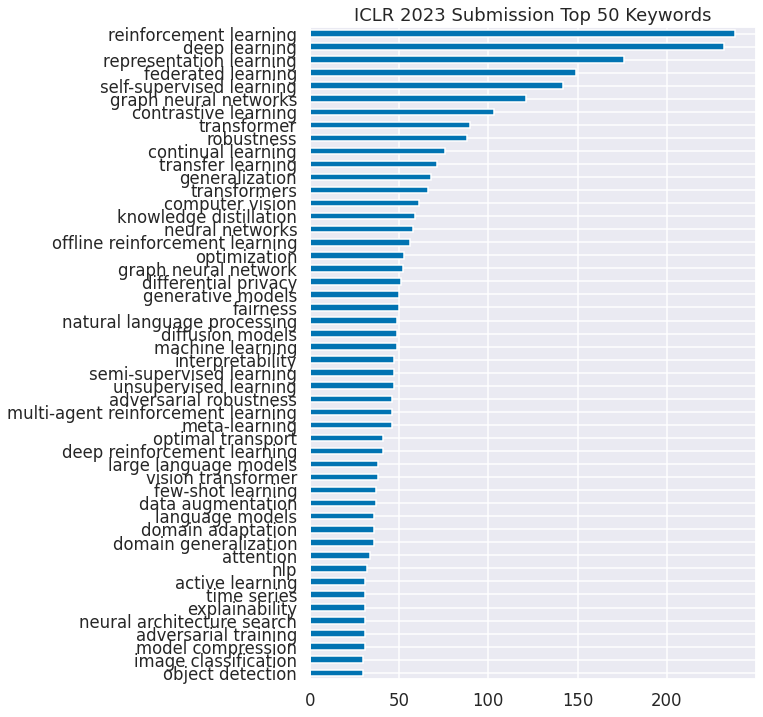

In [84]:
keywords.iloc[-50:].plot.barh(figsize=(8, 12), title='ICLR 2023 Submission Top 50 Keywords')
plt.savefig(f'{image_path}top50_keywords.png', bbox_inches='tight', dpi=300)

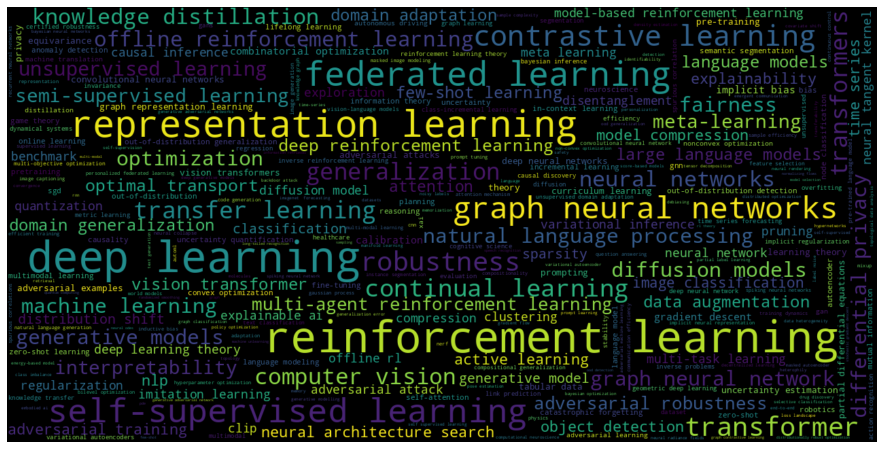

In [87]:
wc = WordCloud(background_color="black", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig(f'{image_path}wordcloud.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_25686/1298044678.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imread('../assets/ICLR-mask.png')


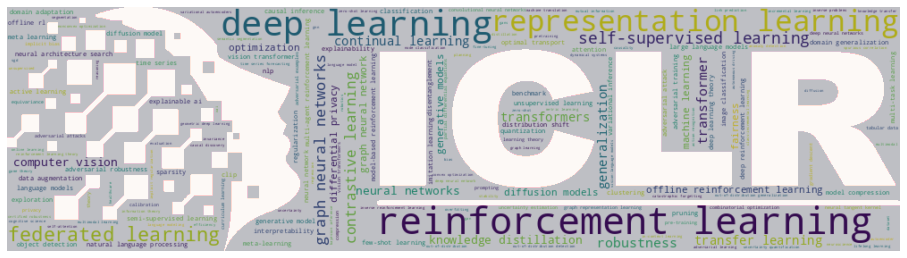

In [88]:
logo = imread('../assets/ICLR-mask.png')
wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0, mask=logo, contour_color='black')
wc.generate_from_frequencies(keywords.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(logo)
plt.imshow(wc, interpolation="bilinear", alpha=.75)
plt.axis("off")
plt.savefig(f'{image_path}wordcloud_nice.png', bbox_inches='tight', dpi=200)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/home/botu/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


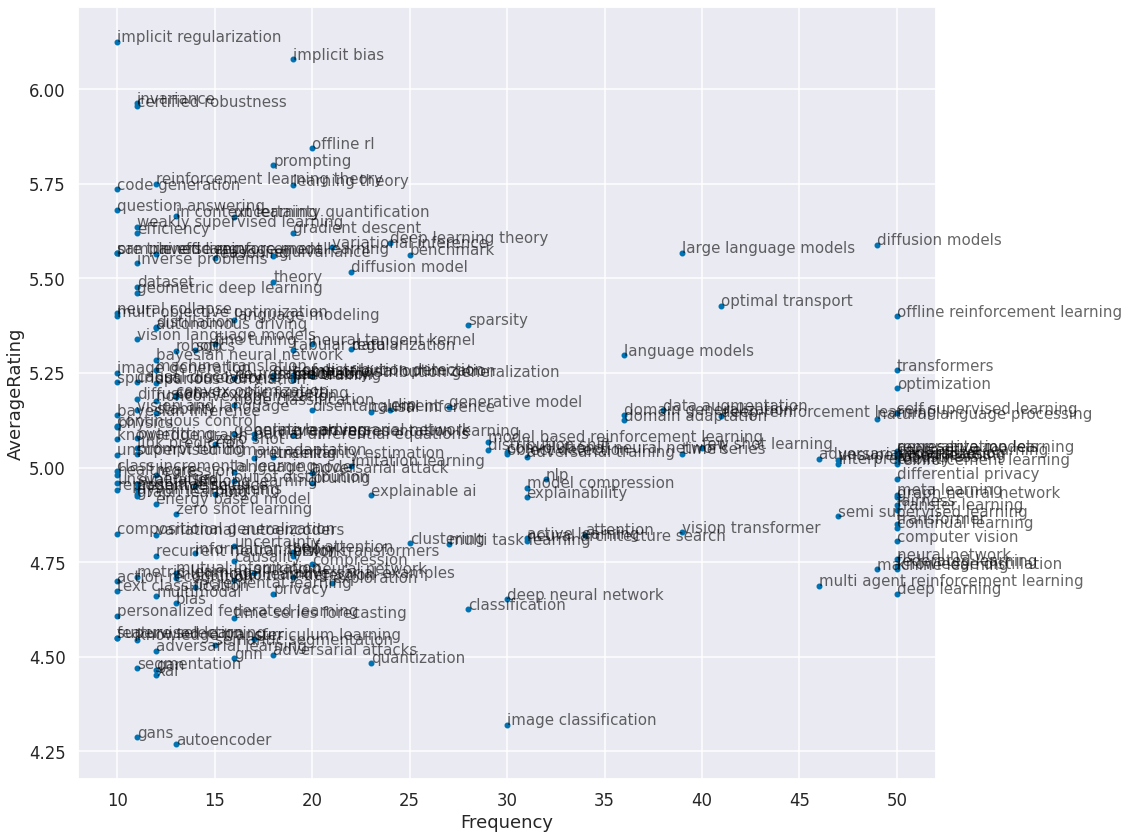

In [89]:
data = {}
for keywords, rating in zip(df.keywords, df.ratings_avg):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords:
        data.setdefault(keyword.lower().replace('-', ' ').replace('networks', 'network').strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>9')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()
plt.savefig(f'{image_path_latest}/keyword_rating.png', bbox_inches='tight', dpi=200)

### Statistics

In [90]:
# all decisions
rating_avgs = df['ratings_avg']

# exclude nan
print("\n> Total submissions (including the withdraw): {}".format(len(rating_avgs)))
# rating_avgs = rating_avgs[~np.isnan(rating_avgs)]
rating_avgs = df['ratings_avg']
print(f"  Avg: {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")

# All except withdraw
rating_avgs = df.query('withdraw!=1')['ratings_avg']
print("\n> Total submissions (excluding the withdraw): {}".format(len(rating_avgs)))
print(f"  Avg (no withdraw): {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")

# Withdrawn
rating_avgs = df.query('withdraw==1')['ratings_avg']
print("\n> Total submissions (only withdraw): {}".format(len(rating_avgs)))
print(f"  Avg (only withdraw): {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")


> Total submissions (including the withdraw): 4874
  Avg: 5.00 ± 1.22

> Total submissions (excluding the withdraw): 4176
  Avg (no withdraw): 5.16 ± 1.20

> Total submissions (only withdraw): 698
  Avg (only withdraw): 4.03 ± 0.74


In [91]:
ratings_avgs = rating_avgs[~np.isnan(rating_avgs)]
rating_avgs.max()

5.75

1.0 8.8
4872


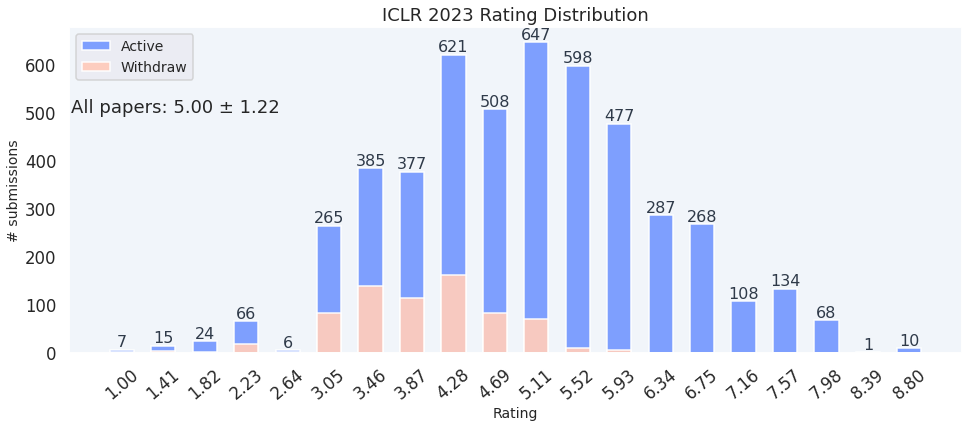

In [97]:
# data = df[df['withdraw'] == 0]['ratings_avg']
rating_avgs = df['ratings_avg']
rating_avgs = rating_avgs[~np.isnan(rating_avgs)]
_min, _max = rating_avgs.min(), rating_avgs.max()
print(_min, _max)

width = 0.24
fig = plt.figure(figsize=[16, 6])

# set background color to white
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor((0.898, 0.925, 0.965, 0.5))
ax.spines['left'].set_color('w')
ax.spines['bottom'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['top'].set_color('w')

# all submissions
hist, bin_edges = np.histogram(rating_avgs, bins=20, range=(_min, _max))
# ax.bar(np.linspace(_min, _max, len(hist)), hist, width=width, alpha=0.95, 
#        color='#789BFF', capsize=4)

# all
ax.bar(np.linspace(_min, _max, len(hist)), hist, width=width, alpha=0.95,
       color='#789BFF', capsize=4, label='Active')

# withdrawn
wd_avgs = df.query('withdraw==1')['ratings_avg']
hist_reject, _ = np.histogram(wd_avgs, bins=20, range=(_min, _max))
ax.bar(np.linspace(_min, _max, len(hist)), hist_reject, width=width, alpha=0.95,
       color='#ffccbd', capsize=4, label='Withdraw')

print(sum(hist))
for i, v in zip(np.linspace(_min, _max, len(hist)), hist):
    ax.text(i - 0.05 * len(str(v)), v + 6.0, str(v), color='#2f3a49', fontsize=16)

ax.text(0.5, 500, f"All papers: {rating_avgs.mean():.2f} ± {rating_avgs.std():.2f}")

# plt.ylim(0, 450)
plt.xticks(ticks=np.linspace(_min, _max, len(hist)), 
           rotation=40, 
           labels=[f"{d:.2f}" for d in np.linspace(_min, _max, len(hist))])
ax.set_ylabel(r"# submissions", fontsize=14)
ax.set_xlabel("Rating", fontsize=14)
ax.set_axisbelow(True)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], loc=2, fontsize=14)
ax.legend(loc=2, fontsize=14)
plt.title('ICLR 2023 Rating Distribution')
# make figure white
plt.savefig(f'{image_path_latest}stats_barplot.png')

In [98]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# Convert to list of int via eval
review_lengths = flatten(df['review_lengths'].apply(lambda x: eval(x)).tolist())
ratings = flatten(df['ratings'].apply(lambda x: eval(x)).tolist())
confidences = flatten(df['confidences'].apply(lambda x: eval(x)).tolist())

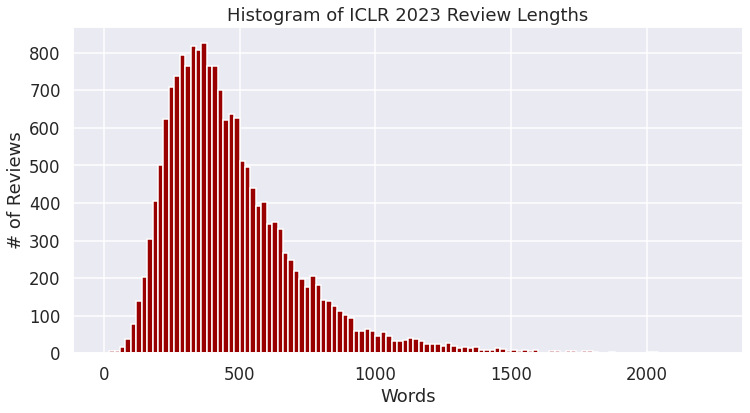

In [99]:
# Plot histograms of review len
fig = plt.figure(figsize=(12, 6))
plt.title('Histogram of ICLR 2023 Review Lengths')


# Review length hist (remove the 10 shortest/longest reviews)
interval = 20
all_review_len_sorted_clip = sorted(review_lengths)[10:-10]
plt.hist(all_review_len_sorted_clip, bins=[v*interval for v in list(
    np.array(range(np.max(all_review_len_sorted_clip)//interval)))],
    color='#990000')
plt.xlabel('Words')
plt.ylabel('# of Reviews')
plt.savefig(f'{image_path_latest}review_length_hist_{date}.png')

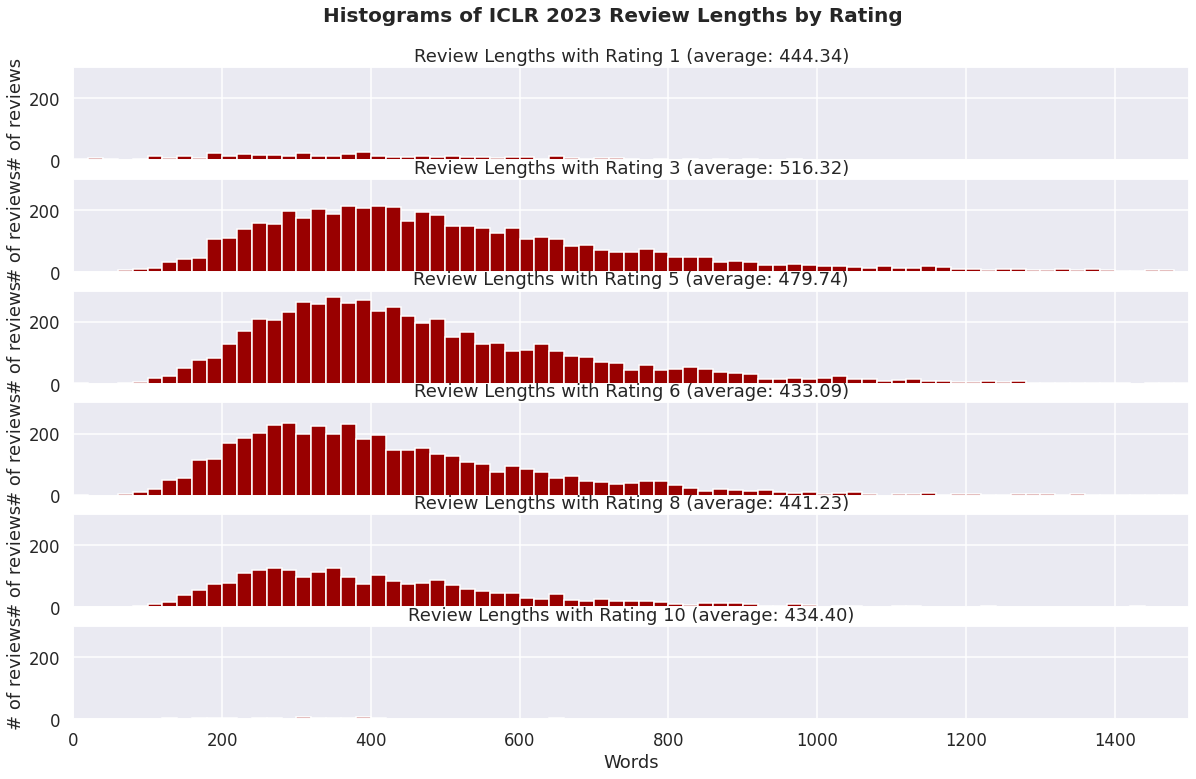

In [100]:
unique_ratings = np.unique(ratings)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_ratings), 1) 
fig = plt.figure(figsize=(20, 12))
for i, unique_rating in enumerate(unique_ratings):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(ratings):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Rating {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_ratings)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 300)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')   
fig.suptitle('Histograms of ICLR 2023 Review Lengths by Rating', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')   
plt.savefig(f'{image_path_latest}review_length_by_rating_{date}.png')

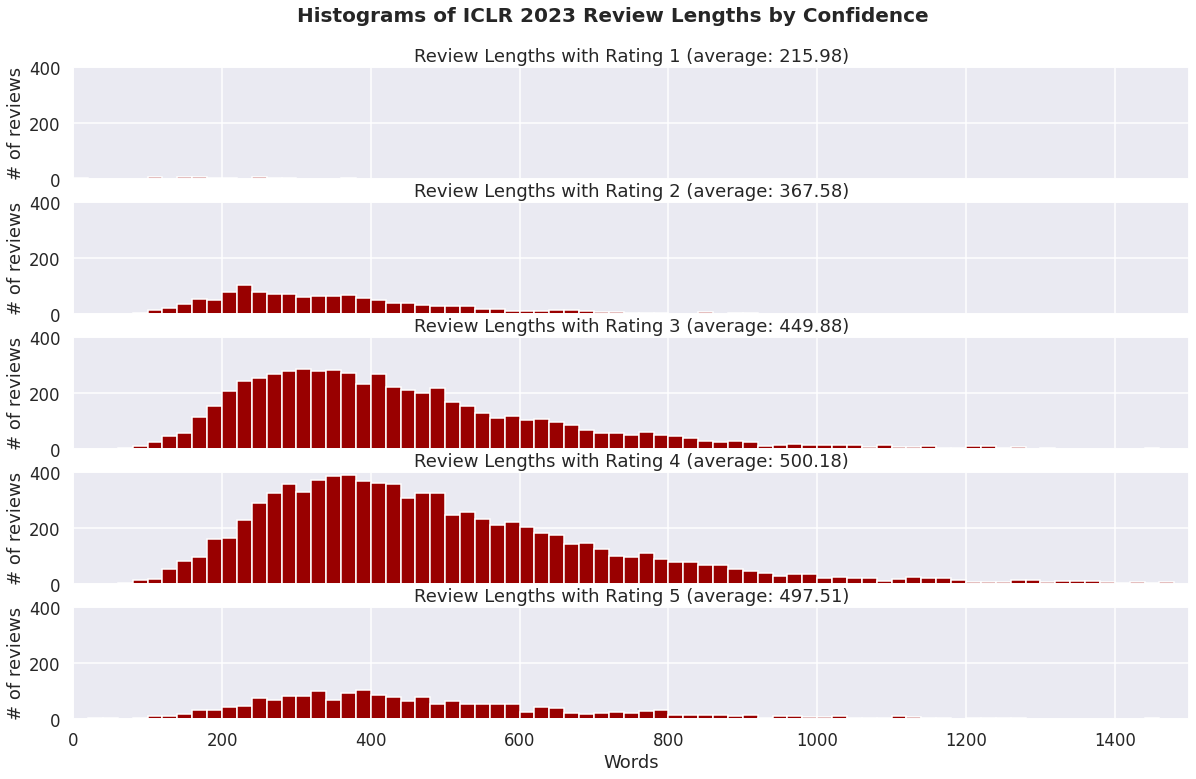

In [101]:
unique_confidences = np.unique(confidences)
bins = [v*interval for v in list(np.array(range(np.max(review_lengths)//interval)))]
gs = gridspec.GridSpec(len(unique_confidences), 1) 
fig = plt.figure(figsize=(20, 12))
for i, unique_rating in enumerate(unique_confidences):
    plt.subplot(gs[i])
    # Plot histograms of review len
    
    # Review length hist
    all_review_len_rating = []
    for j, r in enumerate(confidences):
        if r == unique_rating:
            all_review_len_rating.append(review_lengths[j])
            
    plt.title('Review Lengths with Rating {} (average: {:.2f})'.format(
        unique_rating, np.mean(all_review_len_rating)))
    
    plt.hist(all_review_len_rating, bins=bins, color='#990000')
    if i == len(unique_confidences)-1:
        plt.xlabel('Words')
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    plt.ylim(0, 400)
    plt.xlim(0, 1500)     
    plt.ylabel('# of reviews')   
fig.suptitle('Histograms of ICLR 2023 Review Lengths by Confidence', fontsize=20, fontweight='bold', y=0.95) # or plt.suptitle('Main title')   
plt.savefig(f'{image_path_latest}review_length_by_confidence_{date}.png')

## PDF data

In [105]:
# pdf_data = pd.read_hdf(f'{data_path}{venue_short}_pdf_data_{date}.h5')
pdf_data = pd.read_hdf(f'{data_path}{venue_short}_pdf_data_20221105.h5')
df_full = df.merge(pdf_data, on='id', how='left')
# eliminate nan data
df_full = df_full.dropna(subset=['ratings_avg'])
# drop num pages = 0 (only one paper had a problem in crawling pages)
df_full = df_full[df_full['num_pages'] != 0]
df_full.head()

,id,title,keywords,ratings,confidences,withdraw,review_lengths,ratings_avg,ratings_std,confidence_avg,confidence_std,ratings_avg_old,ratings_old,text,num_characters,num_pages,file_size
0,kRvZ2PcsxjJj,Quantum reinforcement learning,"[quantum reinforcement learning, multi-agent, ...","[1, 1, 1, 1]","[5, 5, 5, 5]",1,"[45, 49, 25, 283]",1.000000,0.000000,5.000000,0.000000,1.000000,"[1, 1, 1, 1]",Under review as a conference paper at ICLR 202...,17955,6,183712
1,RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,[],"[5, 6, 8]","[4, 3, 3]",0,"[443, 274, 401]",6.333333,1.247219,3.333333,0.471405,6.333333,"[5, 6, 8]",QUANTIFYING AND MITIGATING THE IMPACT OF LA-\n...,43936,12,959109
2,N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,"[Lateral Inhibition, Convolutional Neural Netw...","[3, 5, 3, 1]","[5, 5, 5, 5]",0,"[333, 360, 362, 304]",3.000000,1.414214,5.000000,0.000000,3.000000,"[3, 5, 3, 1]",Under review as a conference paper at ICLR 202...,18749,6,202562
3,tmIiMPl4IPa,Factorized Fourier Neural Operators,"[fourier transform, fourier operators, pde, na...","[8, 6, 3, 8, 3]","[5, 4, 4, 2, 2]",0,"[203, 142, 323, 520, 635]",5.600000,2.244994,3.400000,1.200000,5.600000,"[8, 6, 3, 8, 3]",Under review as a conference paper at ICLR 202...,50165,17,1844646
4,mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,"[Pruning, Data Free, Model Compression]","[8, 6, 6]","[3, 2, 3]",0,"[302, 90, 257]",6.666667,0.942809,2.666667,0.471405,6.666667,"[8, 6, 6]",Under review as a conference paper at ICLR 202...,72574,23,1434034


In [106]:
# Plot
def plot_correlation(df, title='Correlation Plot', lenght=20, width=20, save=False):
    '''
    Plot correlation map of input and outputs
    Display only the lower half that matters (since it is a symmetric matrix)
    '''
    plt.figure(figsize=(lenght, width))
    corr = df.corr()
    corr = corr.dropna(axis=1, how='all') # drop NA correlations on rows
    corr = corr.dropna(axis=0, how='all') # drop NA correlations on columns
    mask = np.triu(np.ones_like(corr, dtype=np.bool)) # generate a mask for the upper triangle
    cmap = "RdBu_r" # generate a custom diverging colormap

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        fmt=".2f"
    )
    plt.title(title, fontsize=20, fontweight='bold')
    if save: plt.savefig('Correlation Plot.pdf', bbox_inches='tight')

    # Return dataframe with explanatory variables only
    return df[corr.columns]

In [107]:
df_full['confidence_avg'] = df_full['confidences'].apply(lambda x: np.mean(eval(x)))
df_full['review_lengths_avg'] = df_full['review_lengths'].apply(lambda x: np.mean(eval(x)))

df_values = df_full[['ratings_avg', 'num_pages', 'file_size', 'confidence_avg', 'review_lengths_avg']]

/tmp/ipykernel_25686/3012811790.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool)) # generate a mask for the upper triangle


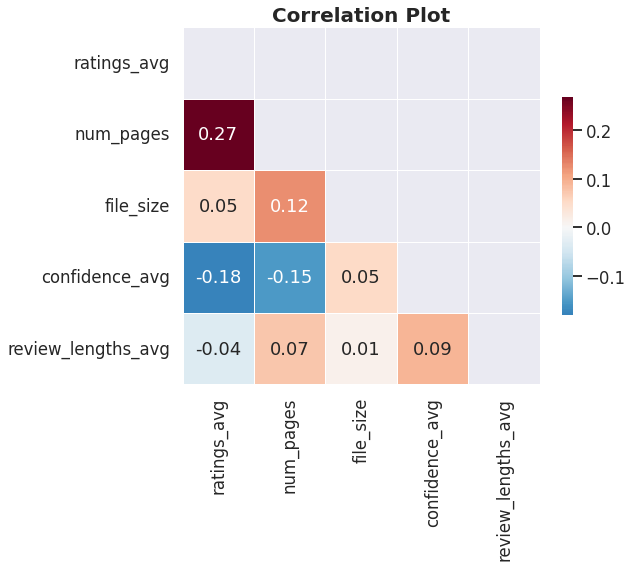

In [108]:
_ = plot_correlation(df_values,  lenght=8, width=8, save=False)

Paper with most pages:  Text and Patterns: For Effective Chain of Thought It Takes Two to Tango 
Pages:  114
Average number of pages: 18.85 


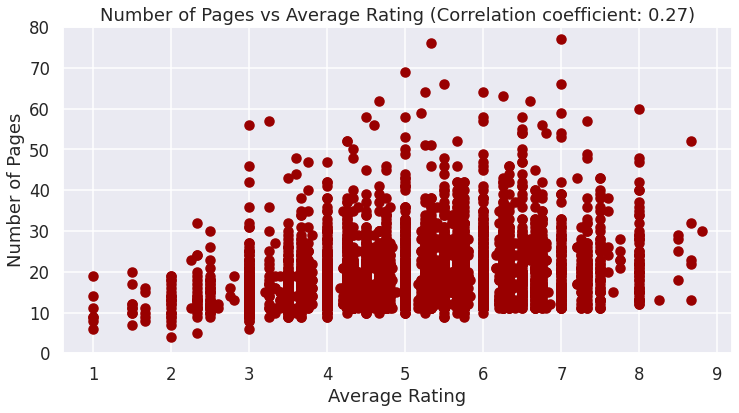

In [109]:
# Plot number of pages vs average ratings
fig = plt.figure(figsize=(12, 6))
plt.title(r"Number of Pages vs Average Rating (Correlation coefficient: {:.2f})".format(np.corrcoef(df_full['ratings_avg'], df_full['num_pages'] / (1024**2))[0, 1]))

plt.scatter(df_full['ratings_avg'], df_full['num_pages'], color='#990000')
plt.xlabel('Average Rating')
plt.ylabel('Number of Pages')
# set limit
plt.ylim(0, 80) # cut paper with more than 50 pages

print("Paper with most pages: ", df_full[df_full['num_pages'] == df_full['num_pages'].max()]['title'].values[0], "\nPages: ", df_full['num_pages'].max())
print("Average number of pages: {:.2f} ".format(df_full['num_pages'].mean()))
plt.savefig(f'{image_path_latest}num_pages_vs_ratings.png')

In [117]:
df_full_ = pd.read_hdf(f'{data_path}{venue_short}_data_full_20221105.h5')
print("Heaviest paper: ", df_full[df_full['file_size'] == df_full['file_size'].max()]['title'].values[0], "\nSize (MB): {:.2f}".format(df_full['file_size'].max() / (1024**2)))
print("Paper with most pages: ", df_full[df_full['num_pages'] == df_full['num_pages'].max()]['title'].values[0], "\nPages: ", df_full['num_pages'].max())
# most_replies = df_full_[df_full_[48].notnull()]
# print("Paper with longest rebuttal: ", most_replies['content.title'].values[0], "\nReplies: ", 48)
# rejected = df_full[(df_full['decision'] != 'Accept')]
# highest_rejected = rejected[rejected['ratings_avg'] == rejected['ratings_avg'].max()]
# print("Highest rated rejected paper: ", highest_rejected['title'].values[0], "\nAverage rating: {:.2f}".format(highest_rejected['ratings_avg'].values[0]))


Heaviest paper:  Proportional Amplitude Spectrum Training Augmentation for Synthetic-to-Real Domain Generalization 
Size (MB): 49.80
Paper with most pages:  Text and Patterns: For Effective Chain of Thought It Takes Two to Tango 
Pages:  114
